# Exercise 12: replica exchange for Lennard-Jones clusters
Molecular and Materials Modelling: ETH Zürich, FS 2023

Date: Wednesday 17. May 2023

Due Date: ?

Raymond Amador, Daniele Passerone, Carlo Pignedoli

ramador@ethz.ch

## 0. Theoretical underpinnings

It is frequently necessary to obtain an ergodic sampling of complex energy landscapes. However, as we have encountered in previous exercises, these landscapes may possess several local minima separated by high energy barriers which are difficult to overcome at ambient temperatures over accessible simulation time scales. This means that the results can be dependent on the initial conditions of the simulation, since the initial conditions determine the region of space explored during the run.

**Replica exchange** simulations seek to enhance the sampling in such scenarios by running several independent simulations of different copies of the system performed at different temperatures, and periodically exchanging the coordinates of replicas between the ensembles according to the **Metropolis criterion**, thereby generating a sort of generalised ensemble of the simulated system. The goal behind replica exchange simulations is to make configurations at high temperatures available to the simulations at low temperatures and vice versa. This results in a very robust ensemble which is ultimately able to sample the free energy landscape by overcoming high-energy potential energy barriers.

![The replica exchange molecular dynamics method. From Qi et.al: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6484850](replica-exchange.png "Figure 1")

## 1. Preparation for the exercise.

In this exercise we will perform the aforementioned replica exchange simulations. 

We begin by logging into our accounts on JupyterHub on Euler in a similar manner as described in the previous exercises, and `pull` the newest exercise files from the GitHub repository, making sure that you are in the directory for the course:
```bash
    $ cd ~/Molecular-and-Materials-Modelling-FS2023
    $ git init
  # $ git stash
    $ git pull https://github.com/ramador09/Molecular-and-Materials-Modelling-FS2023.git
```  
## 2. Simulations with LAAMPS

For this exercise, we are going to perform a parallel tempering simulation with LAMMPS with 12 replicas of the system, modelling each of them in a different processor. Thus, 12 processors are required, one for each replica. Each simulation starts with a different temperature, so we'll have to set up 12 different temperatures:

```
2.00   2.60   3.64   5   6.63   9.12   12.07   16   21.97   26.83   32.76   40.00
```

This is done with the LAMMPS, a software package similar to CP2K, yet LAAMPS differs from CP2K in that LAAMPS focuses on classical molecular dynamics and materials modeling. It is mostly used for simulations of solid-state materials (metals, semiconductors), soft matter (biomolecules, polymers) and coarse-grained or mesoscopic systems. Have a look at the input file with the `vim` editor:

```bash
$ vi input
```

There is an initialization section, showing the kind of units, the dimensionality, the boundary conditions:

```
# Initialization
units            metal
dimension        3
boundary         p p p
atom_style       atomic
```

In the second part of the input file a spherical region is defined (to confine the cluster). Then the atoms are read from the `input.dat` file. We also assign a mass to the kind number 1 (there is just one atomic type for Argon):

```
region rs sphere 0 0 0 12.66
read_data        input.dat
mass 1 39.948
```

Then, we define the parameters for the Lennard-Jones potential. The units are eV for epsilon, and angstrom for sigma. The last number is the cutoff, in Angstrom:

```
pair_style lj/cut 8.5
pair_coeff 1 1 0.01042 3.405  8.5
```

Next, we initialize the fix and the velocity as well as the temperature of each replica. We distribute the temperature exponentially between 2 K and 40 K. In LAMMPS, a `fix` is any operation that is applied to the system during timestepping or minimization. Here we have a `fix` for controlling temperature with NVT (a different temperature for each replica), and a `fix` for applying a harmonic restraint to the spherical region confining the cluster. In this way, the atoms going beyond this region will be elastically pushed back into the sphere. 

```
variable i equal part
variable t world  2.00   2.60   3.64   5   6.63   9.12   12.07   16  ...
velocity        all        create        $t        293288
velocity all zero linear
velocity all zero angular
fix      1      all      nvt    temp    $t      $t      0.1
fix  2 all wall/region rs harmonic 2.0 0.0 0.4
```

The next section is about writing out each 1000 steps the relevant information about temperature and energy. We also dump a restart file at the end, and every 10000 steps a structure in `.xyz` format:

```
thermo         1000
thermo_style        custom        step  temp     pe ke etotal
thermo_modify       line        one
restart 5000000 restart.*
dump         2 all xyz 10000 structure_$i.xyz
dump_modify  2 element "Ar" sort id
```

Finally, we have the command to run the tempering, with an exchange move attempted every 1000th step of molecular dynamics and an initial temperature $\texttt{\$t}$ which is different from replica to replica. The last numbers are random seeds that are used for choosing which replica to exchange and for the Metropolis criterion:

```
temper 5000000 1000 $t 1 3678 3490
```

### "Submitting" the calculation ;-)

Execute the following in your terminal to load the necessary modules:

```bash
$ module load LAMMPS
$ export OMP_NUM_THREADS=${SLURM_CPUS_PER_TASK:-1}
$ export CRAY_CUDA_MPS=1
$ ulimit -s unlimited
```

and then finally execute 

```bash
$ srun -n 12 lmp_mpi -sf gpu -partition 1 1 1 1 1 1 1 1 1 1 1 1 -in input &
```

to start the simulation. The main differences to the submission script from the previous exercises are:
* we execute LAMMPS with the `lmp_mpi` command;
* `-sf gpu` specifies that we run the job with the constraint `gpu`;
* `-partition 1 1 ...` sets up the partitions. In particular, there are twelve 1s, since we want to perform twelve parallel calculations, where each calculation runs on one processor.

## 3. Postprocessing of the simulation
### 3.1 Saving processor information

The calculation should (hopefully) take about 20 minutes. In the meantime, we can go over the input file together. Once the calculations are concluded you will see different output files for all the processors. In particular for every processor (= replica of the system) you will have a trajectory `structure_i.xyz` and two files that describe the evolution of the system in terms of energies and temperature. The postprocesing will be done within this Jupyter notebook. Begin by importing the necessary modules and libraries by executing the first two cell blocks of code:

In [1]:
import numpy as np
import scipy
from scipy.special import sph_harm
from glob import glob
from ase.io import read
from ase import neighborlist
import matplotlib.pyplot as plt

We must now make some postprocessing on the output files with the final goal of performing averages at different temperatures. We begin with the `log` file of LAMMPS. This file contains a table with columns corresponding to different processors (i.e. replicas) and rows corresponding to simulation time. The numbers correspond to the reference temperature (1 = 1st reference temperature = 2K;  2 = 2nd reference temperature = 2.60 K ...). thus, these numbers change according to how the replicas are exchanged. For example, consider the lines:

```
[step  repl.0  repl.1  repl.2  repl.3  repl.4   repl.5     \\
0        0       1       2       3       4        5          \\
0        1       0       2       3       4        5          \\
//       repl.6  repl.7  repl.8  repl.9  repl.10  repl.11] \\
//       6       7       8       9       10       11         \\
//       6       7       8       9       10       11    
```

At the 0th step (first column) processor 0 starts with temperature $T_0$=2 K, processor 1 with temperature $T_1$=2.60 K and so on, according to the input set up. After 1000 steps, an exchange step is attempted and can be accepted according to Boltzmann factor. If the exchange occurs, the temperature of the two processors are inverted, i.e. the temperature of processor 0 becomes 2.60 K and that of processor 1 becomes 2 K. Thus, the configurations of $T_0$=2 K and the one of $T_1$=2.60 K are changing, thus improving the sampling at both temperatures.

Import the dataa nd format it accordingly to the next line of code:

In [2]:
#read data
exchanges = np.loadtxt('./log.lammps', skiprows=3)

#save one column every 10
exchanges = exchanges[0:len(exchanges):10 ,  :]

Secondly, it is necessary to read the `log` files of every system. These files contain tables with columns corresponding to temperature and energies of the replicas simulated in each processor and rows corresponding to simulation time. We store them in a single file named `processor`. Each column processor `i` gives the information for the `i`th processor. The structure of processor `i` files is then:

```
0: step  1: temperature  2: potential energy  3: kinetic energy \\
4: total energy
```

Execute the next cell code block in order to generate these `processor` files:

In [5]:
processor = np.empty((12,501,5))
for i in range(12):
    temporary = np.loadtxt('./log.lammps.'+str(i), skiprows=65, max_rows=5001)
    processor[i] = temporary[0:len(temporary):10 ,  :]

As an instructive example, run the next mini code block to print what the first line of the 10th processor contains:

In [9]:
#example: 10th processor, first line
processor[10][1]

array([ 1.0000000e+04,  3.0400106e+01, -1.5642280e+00,  1.4539232e-01,
       -1.4188357e+00])

### 3.2. Bond order parameters

We now need to create a function for the calculation of bond order parameters (or Steinhardt order parameters), which we have already met in Exercise 3. As a short recap, they are defined as:

$$
Q_l^2 = \frac{4 \pi}{2l+1} \sum_{m=-l}^l |q_{lm}|^2
\qquad
 \text{with}:
 \quad
 q_{lm} = \frac{1}{N_{bonds}} \sum_{N_n} Y_{lm} (\theta_{ij}, \phi_{ij}).
$$

These parameters hold the information of the local structure and are sensitive to different symmetries. Just as in Exercise 3, the center of mass of the full 38-atom cluster is calculated, and thereafter the single nearest neighbour atom to the center of mass is selected. This nearest neighbour plus its own 12 nearest neighbours themselves define the "core" of the total 38-atom cluster. This process is repeated over all vectors pointing from the center of mass of the 38-atom cluster to all $N_b$ bonds over the formed over the  We first define a general `Python` function for $Q_l$ calculation, and then compute $Q_4$ for all the computed trajectories by simply calling the function. Execute the code block which defines a function `QL`, which is of course identical to that in Exercise 3:

In [10]:
def QL(l, trajectory):
    """
    Calculate the QL order parameter for a given trajectory.

    Args:
        l (int): the order of the QL parameter; corresponds to the l in the spherical harmonics
        trajectory (ase.Atoms): the trajectory to be analyzed
    
    Returns:
        Ql (np.array): the Ql order parameter for each frame of the trajectory
    """
    
    rcut = 3.405*1.391/2 #in Angstrom
    
    #update the cutoff for each frame
    for frame in trajectory: 
        array_rcut         = np.ones(len(frame))*rcut
        new_neighbour_list = neighborlist.NeighborList(array_rcut,skin=0, self_interaction=False, bothways=False)
        new_neighbour_list.update(frame)
    
    
    #compute Ql for each frame
    Ql = np.empty(len(trajectory))
    i  = 0
    
    for frame in trajectory:
        nbonds = 0
        qlm    = np.zeros(2*l+1) 
        
        for atom in frame:
            nlist = new_neighbour_list.get_neighbors(atom.index)[0]
                
            for theneig in nlist:   #cycle over the neighbours
                #get angles and distances
                nbonds   = nbonds+1
                rij      = frame[theneig].position - atom.position
                dist     = np.linalg.norm(rij)
                phi_ij   = np.arccos(rij[2]/dist)
                theta_ij = np.arctan2(rij[1],rij[0])
                if theta_ij < 0:
                    theta_ij += 2*np.pi
                
                #move in spherical coordinates space
                    # In a like-oriented coordinate system at j,
                    #the spherical coordinates of atom i are:
                if theta_ij  <= np.pi:
                    theta_ji  = theta_ij + np.pi
                elif theta_ij > np.pi:
                    theta_ji  = theta_ij - np.pi
                if np.absolute(theta_ji-2*np.pi)<0.0001:
                    theta_ji=0.0
                phi_ji = np.pi-phi_ij
                
                #compute spherical harmonics and perform qml summation 
                qlm = qlm + np.array([ sph_harm(m,l,theta_ij,phi_ij) for m in range(-l,l+1) ])
                
        qlm   =  np.real(qlm*np.conj(qlm)/(nbonds*nbonds))
        
        #prefactor and second summation
        Ql[i] =  np.sqrt(np.pi *4 /(2*l+1)*np.sum(qlm))
        i    += 1
    return Ql

Now execute the code block defining `Q4`:

In [11]:
Q4 = np.empty((12,501))
for i in range(12):
    trajectory = read('./exercise-12-outputfiles/structure_'+str(i)+'.xyz', index=':')
    Q4[i] = QL(4, trajectory)

We store the value of $Q_4$ as an extra column of processor `i` files and we name the new outcome as `T_E_Q4`. Each `T_E_Q4` gives the information for the `i`th processor. Execute the code block defining the `T_E_Q4` files:

In [12]:
T_E_Q4 = np.empty((12,501,6))
for i in range(12):
    T_E_Q4[i] = np.column_stack((processor[i], Q4[i]))

Similar to the processor `i` files above, the structure of the `T_E_Q4` files is:

```
0: step  1: temperature  2: potential energy 3: kinetic energy  4: total energy  5: Q4
```

Once again as an instructive example, run the next mini code block to print an example for the 10th processor and how to access various elements of this array:

In [13]:
print(processor[10][0])
print(T_E_Q4[10][0])
print(T_E_Q4[10][0:1000:100])

[ 0.         32.503727   -1.7950808   0.15545315 -1.6396277 ]
[ 0.         32.503727   -1.7950808   0.15545315 -1.6396277   0.07538811]
[[ 0.00000000e+00  3.25037270e+01 -1.79508080e+00  1.55453150e-01
  -1.63962770e+00  7.53881126e-02]
 [ 1.00000000e+06  2.23848780e+01 -1.64284400e+00  1.07058480e-01
  -1.53578550e+00  3.04740301e-02]
 [ 2.00000000e+06  2.41222150e+01 -1.60655990e+00  1.15367520e-01
  -1.49119240e+00  9.78817621e-02]
 [ 3.00000000e+06  1.92330980e+01 -1.64130480e+00  9.19847040e-02
  -1.54932010e+00  7.11532176e-02]
 [ 4.00000000e+06  2.87225060e+01 -1.55797960e+00  1.37368990e-01
  -1.42061060e+00  7.65371499e-02]
 [ 5.00000000e+06  4.02130150e+01 -1.45766360e+00  1.92323790e-01
  -1.26533980e+00  2.19840915e-02]]


### 3.3. Plot: temperature vs. step

We now want to plot the temperature as a function of the step. Do this by executing the function defining this plot:

In [14]:
def plot_temp_vs_step(replica):
    """
    Literally what the name says.

    Args:
        replica (int): the replica to be plotted
    """

    plt.figure(figsize=(10,6))
    plt.plot(T_E_Q4[replica,0::1,0],T_E_Q4[replica,0::1,1], label=str(replica)+'th replica') # T_E_Q4 is a 3D array whose scope is global
    plt.legend(loc='upper right')
    plt.xlabel(' step ')
    plt.ylabel('temperature')
    plt.show()

Notice how the function `plot_temp_vs_step()` takes `replica` as its sole argument. Here we plot the temperature vs. step of the 4th replica:

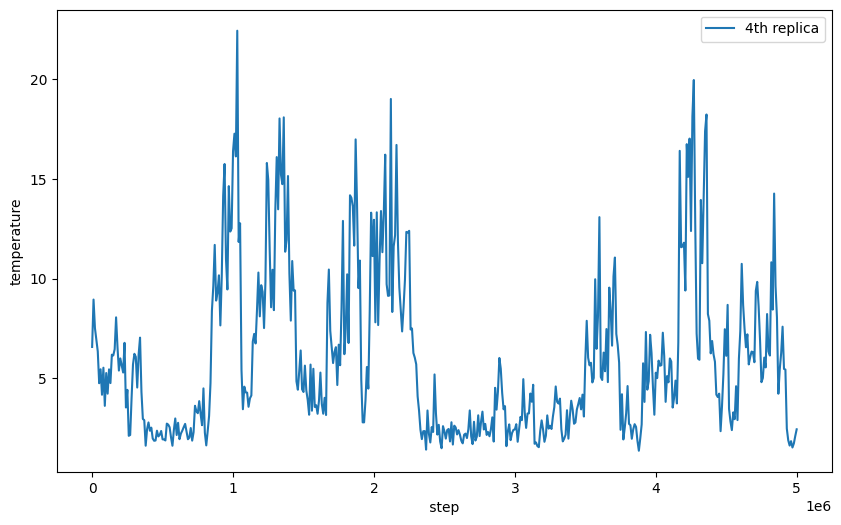

In [15]:
plot_temp_vs_step(4)

#### Assignment 1: Plots of temperature vs. step
Generate the plots of a few (say, three to five) of the rest of the replicas and comment on their appearance: what's going on here with this oscillatory behaviour?

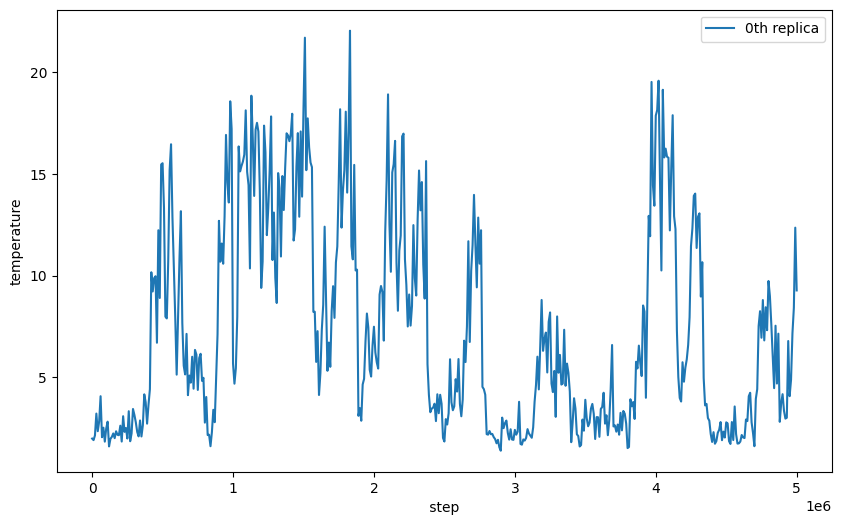

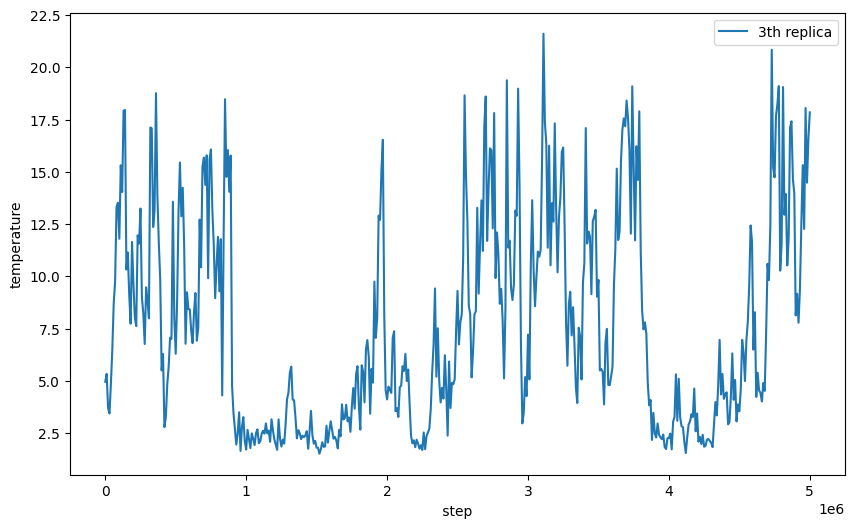

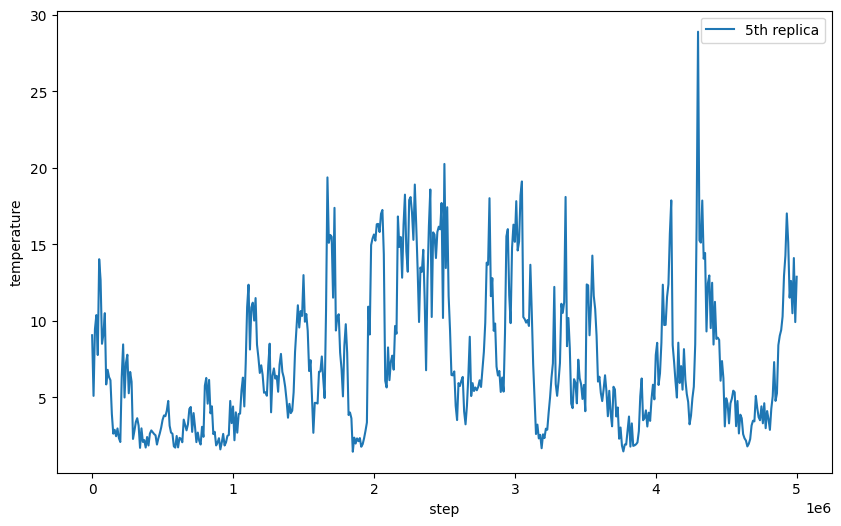

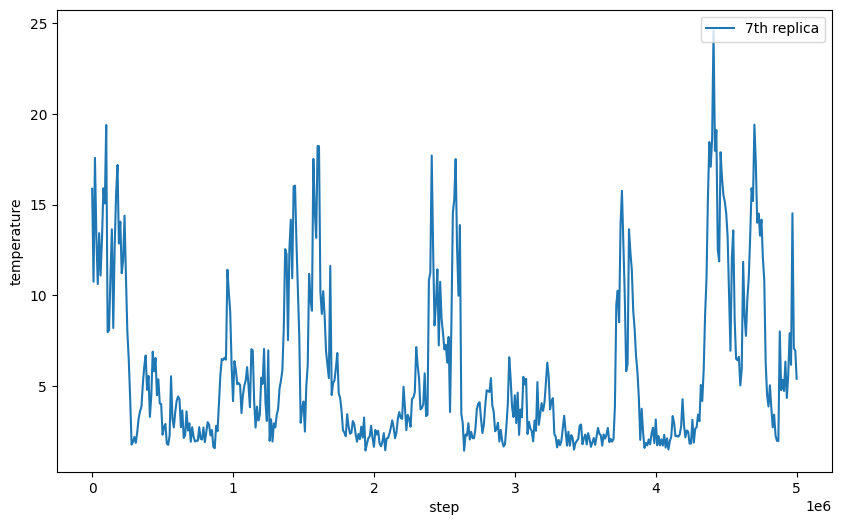

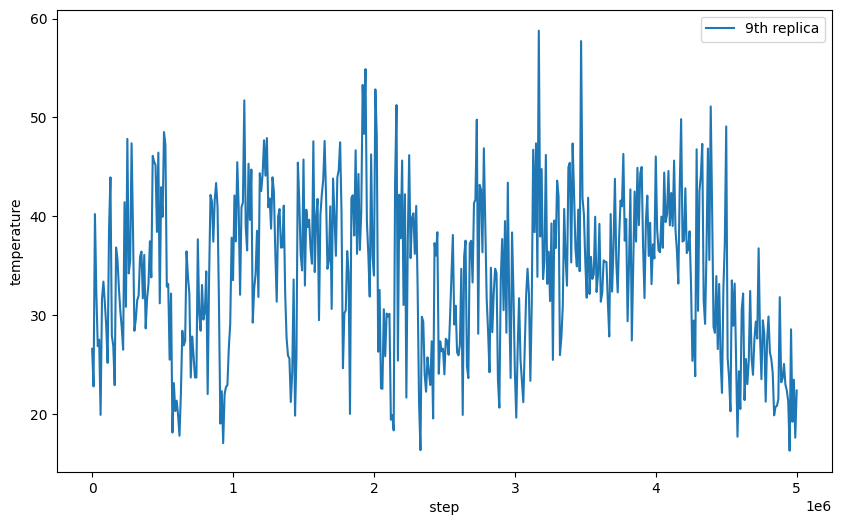

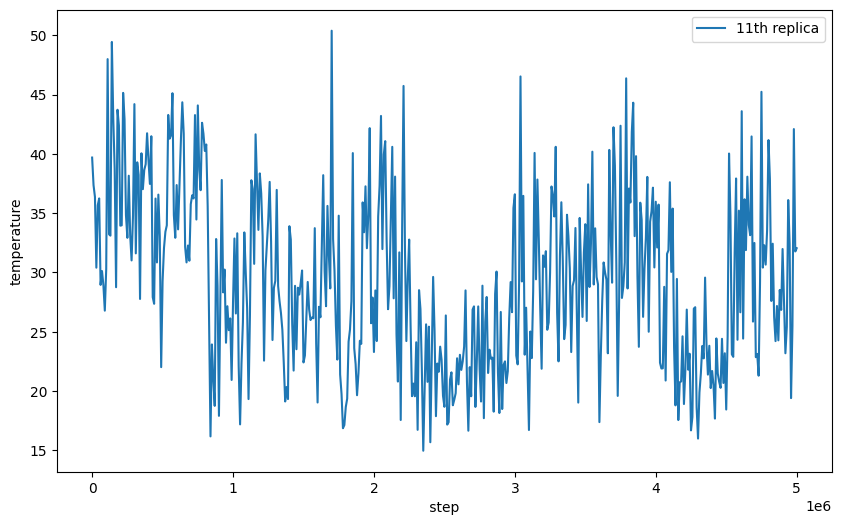

In [17]:
## Your code here
plot_temp_vs_step(0)
plot_temp_vs_step(3)
plot_temp_vs_step(5)
plot_temp_vs_step(7)
plot_temp_vs_step(9)
plot_temp_vs_step(11)

The strong oscillations are a result of the replica exchanges. For example, the 0st replica starts at low temperature (prescribed 2K) and then an exchange happens and hence its temperature changes. We can see, that te 0st replica always comes back to the low temperature, while for example the 11th replica (the las one, with 40K) never reaches temperatures lower than 15K. Simliarly the 0st replica never reaches higher temperatures than 20K. This is because of the acceptance probability in the exchange step. Note that it would be possible, that 0st and 11th exchanging, but the probability is just very low.

#### End Assignment 1

#### Assignment 2: Plot of $Q_4$ vs. step

Generate the $Q_4$ plot as a function of step for the same replicas you chose in Assignment 1 and comment a bit on the behaviour.

In [28]:
## Your code here
def plot_Q4_vs_step(replica):
    """
    Literally what the name says.

    Args:
        replica (int): the replica to be plotted
    """

    plt.figure(figsize=(10,6))
    plt.plot(T_E_Q4[replica,0::1,0],T_E_Q4[replica,0::1,-1], label=str(replica)+'th replica') # T_E_Q4 is a 3D array whose scope is global
    plt.legend(loc='upper right')
    plt.xlabel(' step ')
    plt.ylabel('Q4')
    plt.show()

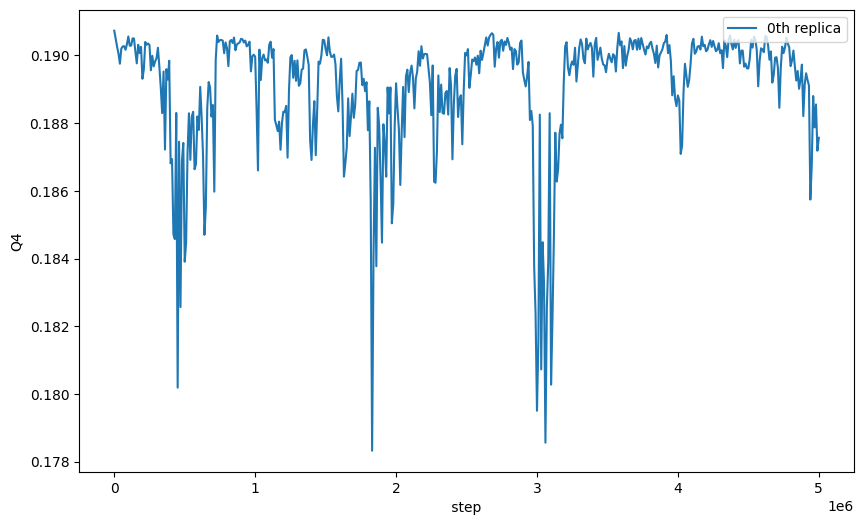

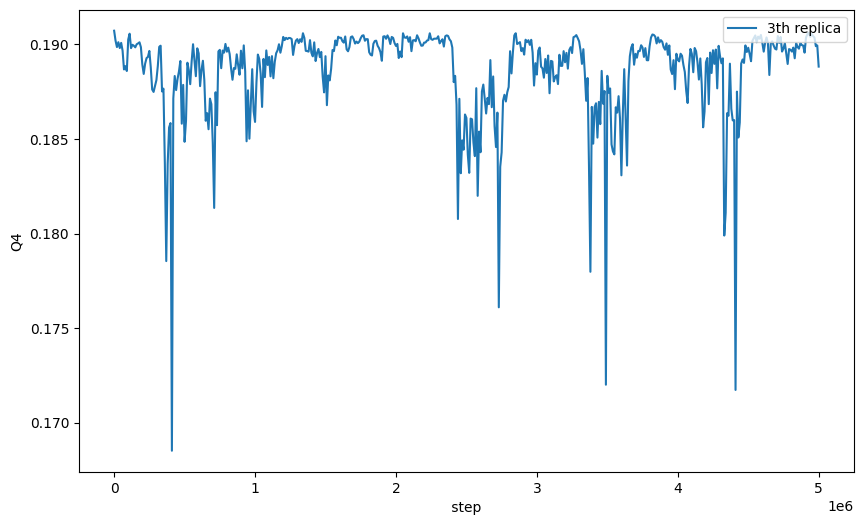

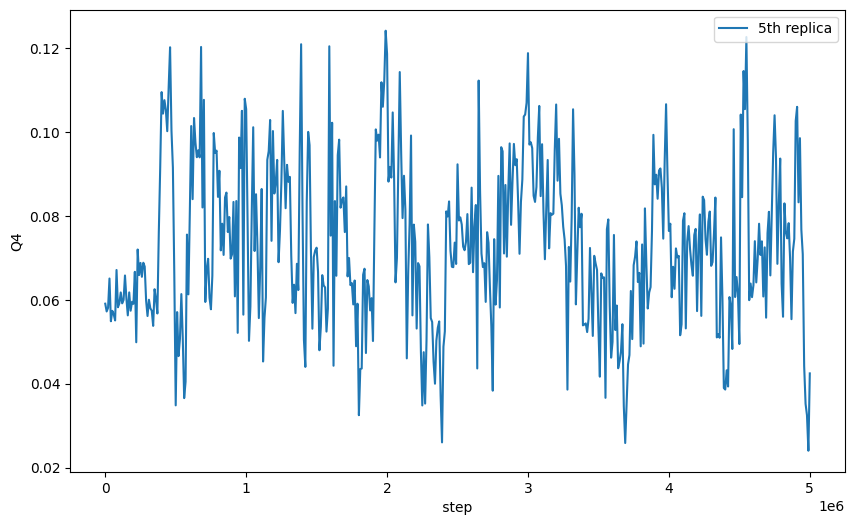

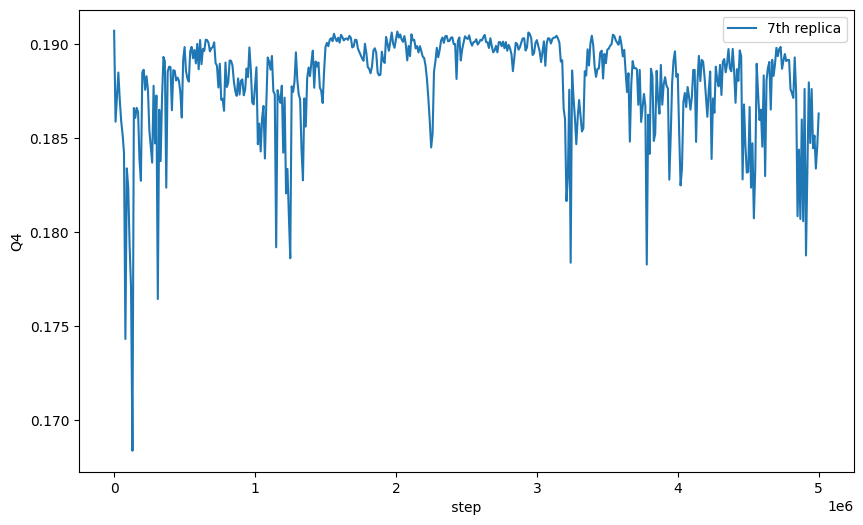

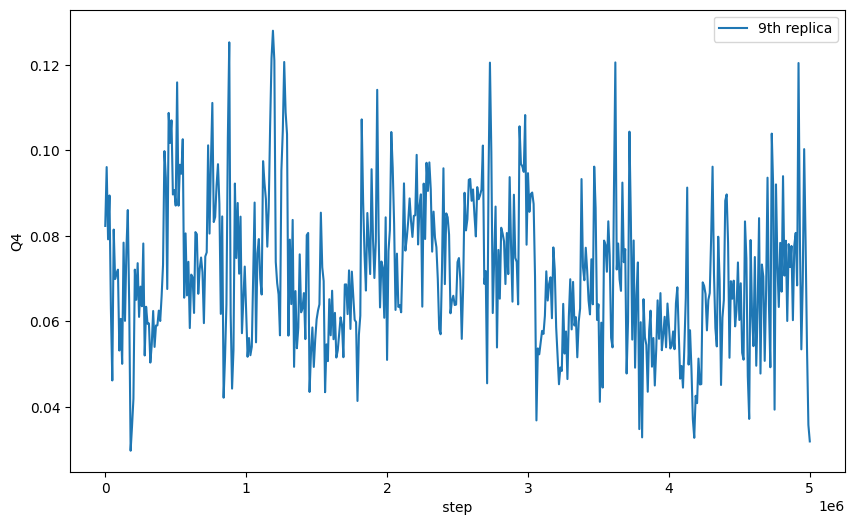

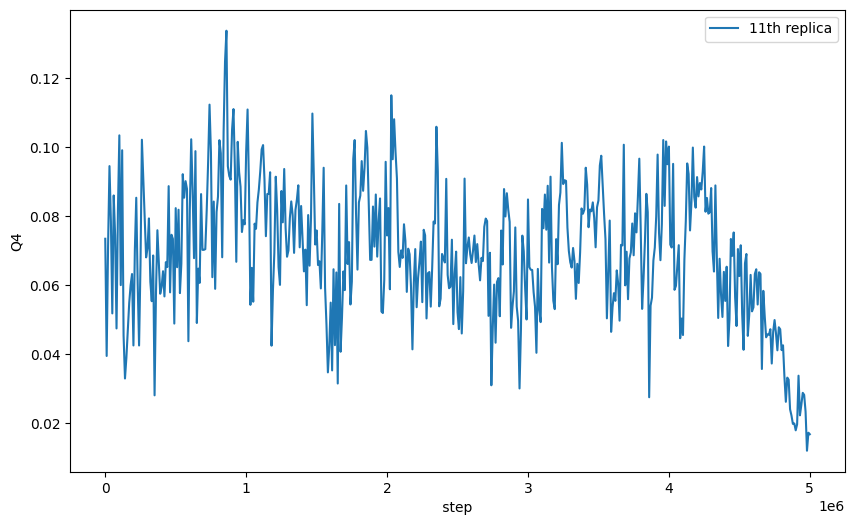

In [29]:
plot_Q4_vs_step(0)
plot_Q4_vs_step(3)
plot_Q4_vs_step(5)
plot_Q4_vs_step(7)
plot_Q4_vs_step(9)
plot_Q4_vs_step(11)

As expected, lower replicas are more symmetric (higher Q4 number), due to less fluctuations. Note that tha maximum value of 0.19 is still not very high. When the temperatures increase, the symmetry reduces (compare with the temperatures above). Interesingely though, the 7th replica is still more symmetric than the 5th one even though it has higher tmeperature at the beginning.

#### End Assignment 2

### 3.4. Classification according to temperature

Up to now, the information collected in the `T_E_Q4[i]` columns took the replicas as reference: the replica itself was kept fixed, while we allowed the temperature to change. We now want exactly the reverse, i.e. we want to have files with fixed temperature and changing replicas. The `exchanges` array computed at the beginning of this exercise session keeps track of the temperature exchanges, telling us at a given timestep which replica has which temperature. We use it to create a single file for each temperature containing the information of the corresponding system.

We begin by focusing on one temperature per time, for example the one labelled as 5. Let's say that the `exchanges` array at the step 50000 shows the following line:

```
[step  repl.0  repl.1  repl.2  repl.3  repl.4   repl.5 \\
50000    1       0       2       3       4        7          \\

repl.6  repl.7  repl.8  repl.9  repl.10  repl.11] \\
//       8       6       5       11      9        10 
```

This table indicates that at replica 8, we have the temperature 5 of interest, which is $T_5$=6.63 K according to the input. Thus, at step 50000, the thermostat is keeping replica 8 around the temperature $T_5$.

At the same step (50000), the column of the array containing the information of replica 8 shows the following line:

```
50000  7.92921980  -1.75593550  0.0379224880  -1.71801300  0.188043758
```

since the data are stored every 1000th step. Thus this line is the 5th line of the `T_E_Q4[8]` array, i.e., the element `T_E_Q4[8][5]`. The idea is to save this line in a specific file for the $T_5$ temperature. Execute the following cell:

In [30]:
def split_T_E_Q4_by_exchange(exchanges, T_E_Q4):
    """
    Split the 3D array T_E_Q4 by exchange type based on the values in the 2D
    array exchanges. Each row of the exchanges array represents a timestep and
    contains an exchange type (0 to 12) for each processor. The resulting
    output is a dictionary where the keys are the exchange types and the values
    are 2D arrays representing T_E_Q4 for the corresponding exchange type.

    Args:
    exchanges (ndarray): A 2D array of shape (num_timesteps, num_processors+1) that
        contains the exchange type for each processor at each timestep. We defined it at the beginning of the notebook.

    T_E_Q4 (ndarray): A 3D array of shape (num_processors, num_timesteps, 6) that
        contains the data to be split by exchange type.

    Returns:
    T: A dictionary where the keys are the exchange types (integers from 0 to 12)
        and the values are 2D arrays of shape (num_timesteps_for_exchange, 6) that
        contain the corresponding data from T_E_Q4.
    """
    T = {i: np.empty((0, 6)) for i in range(13)}
    for T_idx in range(len(exchanges)):
        for proc_idx in range(12):
            exchange_val = int(exchanges[T_idx][proc_idx+1])
            T[exchange_val] = np.append(T[exchange_val], [T_E_Q4[proc_idx][T_idx]], axis=0)
    return T


In [25]:
"""
Alternate code:
----------------
#Make empty array
for i in range(12):
    globals()["T_"+str(i)] = np.empty((0,6))

for T in range(len(exchanges)):
    for proc in range(12):
        if exchanges[T][proc+1]==0:
            T_0 = np.append(T_0, [T_E_Q4[proc][T]], axis=0)
        if exchanges[T][proc+1]==1:
            T_1 = np.append(T_1, [T_E_Q4[proc][T]], axis=0)
        if exchanges[T][proc+1]==2:
            T_2 = np.append(T_2, [T_E_Q4[proc][T]], axis=0)
        if exchanges[T][proc+1]==3:
            T_3 = np.append(T_3, [T_E_Q4[proc][T]], axis=0)
        if exchanges[T][proc+1]==4:
            T_4 = np.append(T_4, [T_E_Q4[proc][T]], axis=0)
        if exchanges[T][proc+1]==5:
            T_5 = np.append(T_5, [T_E_Q4[proc][T]], axis=0)
        if exchanges[T][proc+1]==6:
            T_6 = np.append(T_6, [T_E_Q4[proc][T]], axis=0)
        if exchanges[T][proc+1]==7:
            T_7 = np.append(T_7, [T_E_Q4[proc][T]], axis=0)
        if exchanges[T][proc+1]==8:
            T_8 = np.append(T_8, [T_E_Q4[proc][T]], axis=0)
        if exchanges[T][proc+1]==9:
            T_9 = np.append(T_9, [T_E_Q4[proc][T]], axis=0)
        if exchanges[T][proc+1]==10:
            T_10 = np.append(T_10, [T_E_Q4[proc][T]], axis=0)
        if exchanges[T][proc+1]==11:
            T_11 = np.append(T_11, [T_E_Q4[proc][T]], axis=0)
        if exchanges[T][proc+1]==12:
            T_12 = np.append(T_12, [T_E_Q4[proc][T]], axis=0)
"""

'\nAlternate code:\n----------------\n#Make empty array\nfor i in range(12):\n    globals()["T_"+str(i)] = np.empty((0,6))\n\nfor T in range(len(exchanges)):\n    for proc in range(12):\n        if exchanges[T][proc+1]==0:\n            T_0 = np.append(T_0, [T_E_Q4[proc][T]], axis=0)\n        if exchanges[T][proc+1]==1:\n            T_1 = np.append(T_1, [T_E_Q4[proc][T]], axis=0)\n        if exchanges[T][proc+1]==2:\n            T_2 = np.append(T_2, [T_E_Q4[proc][T]], axis=0)\n        if exchanges[T][proc+1]==3:\n            T_3 = np.append(T_3, [T_E_Q4[proc][T]], axis=0)\n        if exchanges[T][proc+1]==4:\n            T_4 = np.append(T_4, [T_E_Q4[proc][T]], axis=0)\n        if exchanges[T][proc+1]==5:\n            T_5 = np.append(T_5, [T_E_Q4[proc][T]], axis=0)\n        if exchanges[T][proc+1]==6:\n            T_6 = np.append(T_6, [T_E_Q4[proc][T]], axis=0)\n        if exchanges[T][proc+1]==7:\n            T_7 = np.append(T_7, [T_E_Q4[proc][T]], axis=0)\n        if exchanges[T][proc+

The resulting `T` arrays will have the same structure as the `T_E_Q4[i]` array, namely

```
0: step  1: temperature  2: potential energy 3: kinetic energy  4: total energy  5: Q4
```

However, in this case, it is temperature which will be kept constant, while the replica will vary; Section 3.3. was exactly the opposite case. Convince yourself of the structure of the `T_E_Q4[i]` and `T_i` objects by executing the block of code

In [31]:
T = split_T_E_Q4_by_exchange(exchanges,T_E_Q4)

# example for the 10th processor: first line of T_E_Q4[10] (fixed processor) vs. first line of T_10 (fixed temperature)
print('example for the 10th processor: first line of T_E_Q4[10] (fixed processor) VS first line of T_10 (fixed temperature):')
print(T_E_Q4[10][0])
print(T[10][0])
print('\n--------------------------------------------------')
print('--------------------------------------------------\n')

#example for the 10th processor: 290th line of T_E_Q4[10] (fixed processor) vs. 290th line of T_10 (fixed temperature)
print('example for the 10th processor: 290th line of T_E_Q4[10] (fixed processor) VS 290th line of T_10 (fixed temperature):')
print(T_E_Q4[10][290])
print(T[10][290])

example for the 10th processor: first line of T_E_Q4[10] (fixed processor) VS first line of T_10 (fixed temperature):
[ 0.         32.503727   -1.7950808   0.15545315 -1.6396277   0.07538811]
[ 0.         32.503727   -1.7950808   0.15545315 -1.6396277   0.07538811]

--------------------------------------------------
--------------------------------------------------

example for the 10th processor: 290th line of T_E_Q4[10] (fixed processor) VS 290th line of T_10 (fixed temperature):
[ 2.90000000e+06  3.26486080e+01 -1.62301950e+00  1.56146060e-01
 -1.46687340e+00  7.07435541e-02]
[ 2.90000000e+06  3.36410700e+01 -1.51417900e+00  1.60892640e-01
 -1.35328640e+00  8.96296056e-02]


### 3.5. Plots of potential energy

As we've done in the previous exercises, we can play around with all the data we now have from the output files. We now want to plot the potential energy as a function of the step for both the 0th replica and the 11th replica, i.e., the potential energy plot for a hot replica vs. a cold replica. Do this by executing the block of code in this section:

Text(0, 0.5, 'potential energy')

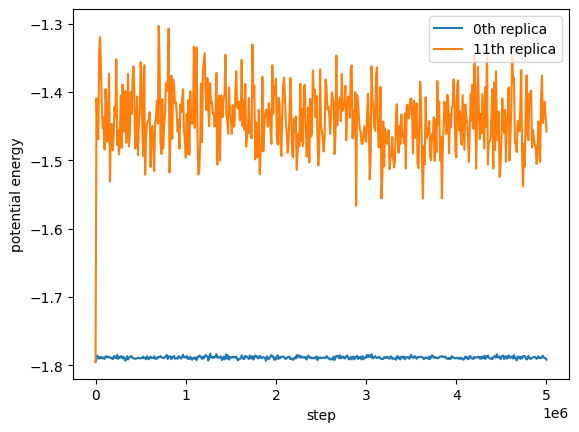

In [32]:
plt.plot(T[0][0::1,0], T[0][0::1,2], label='0th replica')
plt.plot(T[11][0::1,0], T[11][0::1,2], label='11th replica')
plt.legend(loc='upper right')
plt.xlabel('step')
plt.ylabel('potential energy')

#### Assignment 3: Second plot of temperature vs. step

Plot temperature vs. step again, this time using the `T_i` arrays. Compare this plot
to those generated in Assignment 1: how and why are they different? *Hint*: in the
present plot, we use the `T_i` arrays; in the plot of Assignment 1, we use the `T_E_Q4`
arrays. How are their respective definitions different, and how does this difference
manifest itself in these plots?

In [38]:
## Your code here
def plot_temp_vs_step_fixed_T(replica):
    """
    Literally what the name says.

    Args:
        replica (int): the replica to be plotted
    """

    plt.figure(figsize=(10,6))
    plt.plot(T[replica][0::1,0],T[replica][0::1,1], label=f"T{replica}") # T_E_Q4 is a 3D array whose scope is global
    plt.legend(loc='upper right')
    plt.xlabel(' step ')
    plt.ylabel('temperature')
    plt.show()

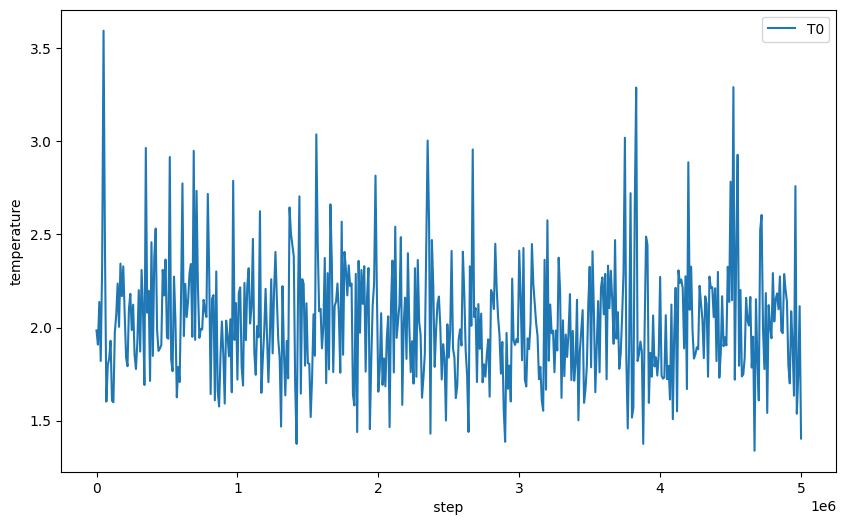

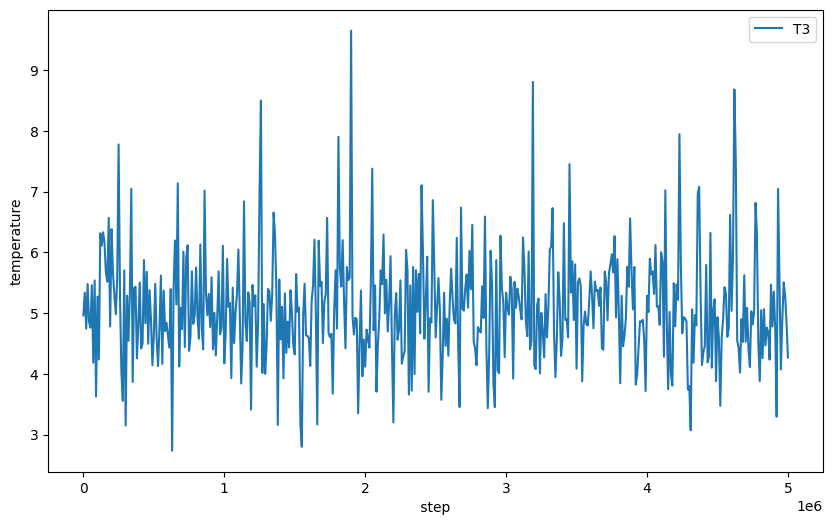

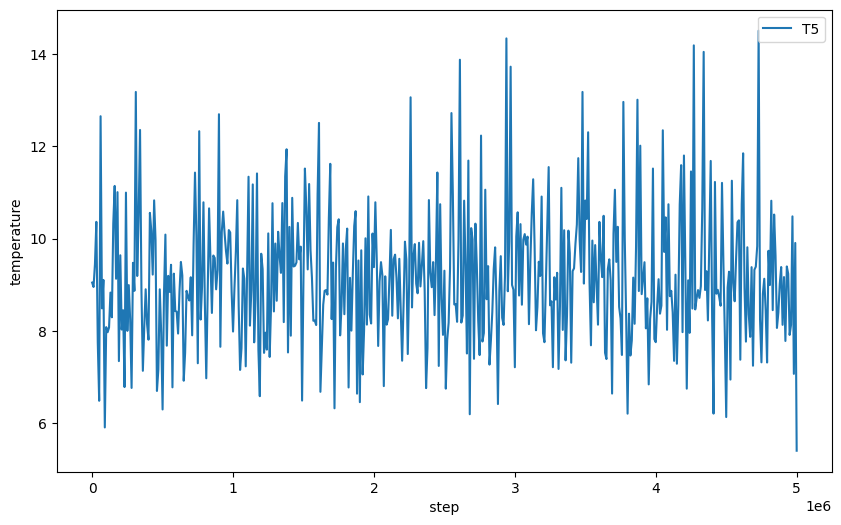

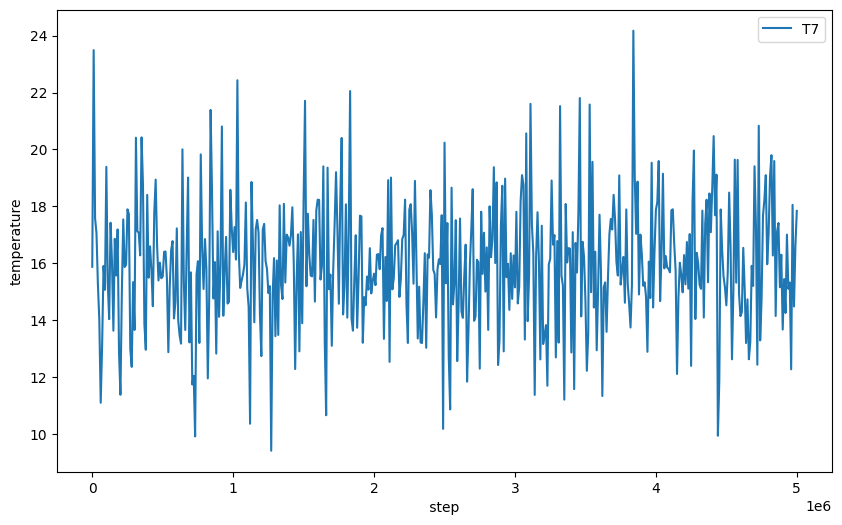

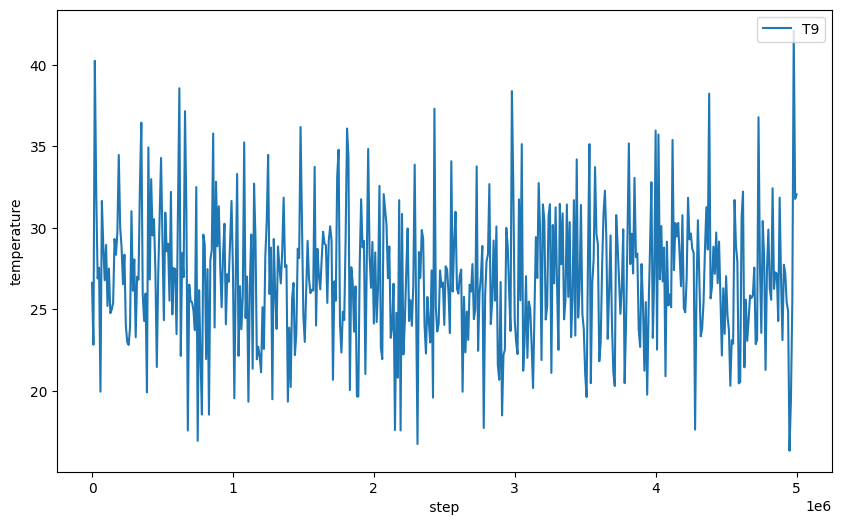

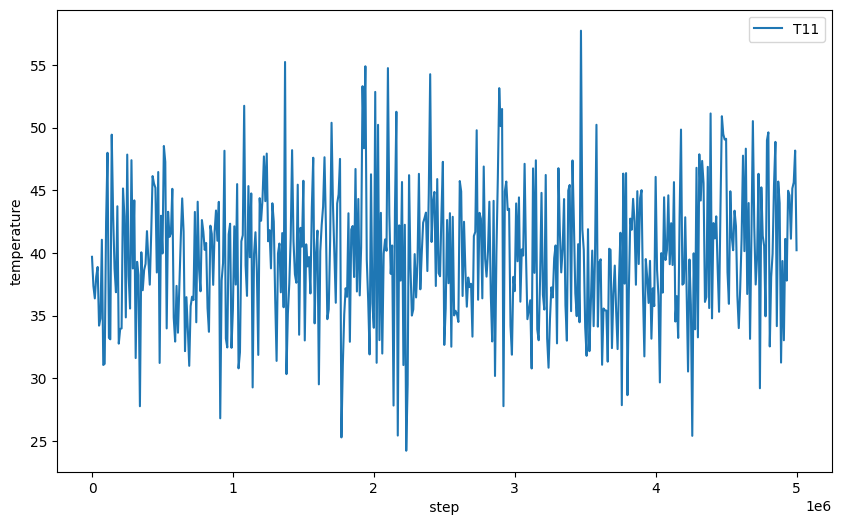

In [39]:
plot_temp_vs_step_fixed_T(0)
plot_temp_vs_step_fixed_T(3)
plot_temp_vs_step_fixed_T(5)
plot_temp_vs_step_fixed_T(7)
plot_temp_vs_step_fixed_T(9)
plot_temp_vs_step_fixed_T(11)

Now the temperature seem to be constant (up to natural fluctuation). This is not surprising, as we collected the data such that we follow e given temperature through its exchanges.

#### End Assignment 3

### 3.6. Plots of $Q_4$

Now let us plot the $Q_4$ according to the temperature as a function of the steps, also for the 0th and 11th replicas. Do this by executing the cell block:

Text(0, 0.5, '$Q_4$')

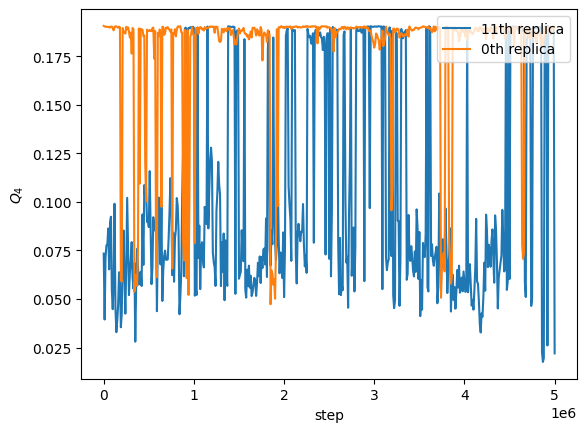

In [40]:
plt.plot(T[11][0::1,0], T[11][0::1,5], label='11th replica')
plt.plot(T[0][0::1,0], T[0][0::1,5], label='0th replica')
plt.legend(loc='upper right')
plt.xlabel('step')
plt.ylabel('$Q_4$')

## 4. Averages

In this last section, we wish to extract the averages as a function of temperature. We create an array of averages containing the following structure:

```
0: temperature  1: potential energy  2: kinetic energy 3: total energy  4: Q4
```

Do this by executing the following function, `calculate_averages()`:

In [44]:
def calculate_averages(T):
    """
    Calculates the means of the second through sixth columns of the 2D arrays
    in the values of the dictionary T, and returns them as a 2D numpy array.
    
    Args:
    T (dict): A dictionary where the keys are the replicas (integers from 0 to 12), and the
              values are 2D numpy arrays of shape (num_timesteps_for_exchange, 6).
    
    Returns:
    numpy.ndarray: A 2D numpy array of shape (13, 5) where each row corresponds
                   to the means of the second through sixth columns of the 2D
                   array in the corresponding value of T.
    """
    # initialize the array to hold the averages
    averages = np.empty((0,5))

    # iterate through the dictionary and calculate the means for each 2D array
    for i in range(12):
        means = np.mean(T[i][:,1:6], axis=0).reshape(1,-1)
        averages = np.append(averages, means, axis=0)

    return averages

In [26]:
"""
Alternate code:
----------------

averages = np.empty((0,5))
#append values for each temperature
averages = np.append(averages, [np.mean(T_0, axis=0)[1:6]], axis=0)
averages = np.append(averages, [np.mean(T_1, axis=0)[1:6]], axis=0)
averages = np.append(averages, [np.mean(T_2, axis=0)[1:6]], axis=0)
averages = np.append(averages, [np.mean(T_3, axis=0)[1:6]], axis=0)
averages = np.append(averages, [np.mean(T_4, axis=0)[1:6]], axis=0)
averages = np.append(averages, [np.mean(T_5, axis=0)[1:6]], axis=0)
averages = np.append(averages, [np.mean(T_6, axis=0)[1:6]], axis=0)
averages = np.append(averages, [np.mean(T_7, axis=0)[1:6]], axis=0)
averages = np.append(averages, [np.mean(T_8, axis=0)[1:6]], axis=0)
averages = np.append(averages, [np.mean(T_9, axis=0)[1:6]], axis=0)
averages = np.append(averages, [np.mean(T_10, axis=0)[1:6]], axis=0)
averages = np.append(averages, [np.mean(T_11, axis=0)[1:6]], axis=0)
#print(averages)
"""

'\nAlternate code:\n----------------\n\naverages = np.empty((0,5))\n#append values for each temperature\naverages = np.append(averages, [np.mean(T_0, axis=0)[1:6]], axis=0)\naverages = np.append(averages, [np.mean(T_1, axis=0)[1:6]], axis=0)\naverages = np.append(averages, [np.mean(T_2, axis=0)[1:6]], axis=0)\naverages = np.append(averages, [np.mean(T_3, axis=0)[1:6]], axis=0)\naverages = np.append(averages, [np.mean(T_4, axis=0)[1:6]], axis=0)\naverages = np.append(averages, [np.mean(T_5, axis=0)[1:6]], axis=0)\naverages = np.append(averages, [np.mean(T_6, axis=0)[1:6]], axis=0)\naverages = np.append(averages, [np.mean(T_7, axis=0)[1:6]], axis=0)\naverages = np.append(averages, [np.mean(T_8, axis=0)[1:6]], axis=0)\naverages = np.append(averages, [np.mean(T_9, axis=0)[1:6]], axis=0)\naverages = np.append(averages, [np.mean(T_10, axis=0)[1:6]], axis=0)\naverages = np.append(averages, [np.mean(T_11, axis=0)[1:6]], axis=0)\n#print(averages)\n'

and examine its structure using the next cell block as an example for `T[7]`: the first value corresponds to the target temperature of replica 7 (=16 K) of the input file:

In [45]:
#example for T[7]: the first value should correspond to the target temperature 7 (~16K) of the input file
calculate_averages(T)[7][0]

15.954502861477044

#### Assignment 4: Final plot of $Q_4$

Plot the $Q_4$ as function of the temperature one last time. You have to transpose the matrix adding the `.T` suffix, i.e., `calculate_averages(T).T`, and select the component that you want to plot according to the structure of the array given above, e.g., the 0 for the temperature `calculate_averages(T).T[0]` and the 4 for the $Q_4$ `averages.T[4]`. Start by defining two parameters `epsilon` and `kB`:

In [55]:
epsilon = 119.8*8.616733e-5 # eV
kB = 8.617e-5 #eV/K

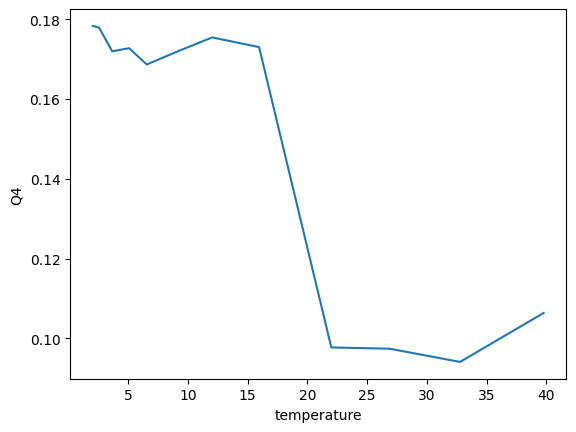

In [49]:
## Your code here
avgs = calculate_averages(T).T
plt.plot(avgs[0], avgs[4], label="Q4")
plt.xlabel("temperature")
plt.ylabel("Q4")
plt.show()

Compare your result with the top panel of Figure 2 of [this paper](https://aip.scitation.org/doi/pdf/10.1063/1.481671) and see if you recover the same trend

The same trend as in the referenced paper can be observed.

#### End Assignment 4

#### Assignment 5: heat capacity at constant volume

Statistical mechanics defines the **heat capacity at constant volume** $C_V$ in terms of the fluctuations of variance of energy compared to the square of the expectation value of energy:

$$
C_V = k_B\beta^2[\langle E^2 \rangle - \langle E \rangle^2].
$$

Plot this quantity vs. the temperature (your plot might look nicer, however, if you plot the normalised expectation value of $C_V$ vs the normalised temperature: $\langle C_V \rangle / Nk_B$ vs. $k_BT/\varepsilon$). Recover the plot in the top panel of FIG. 1 of the paper cited in Assignment 4.

**If you feel like it**: carry out the differentiation in Eq. (15) of the paper and reproduce the bottom panel of FIG. 1.

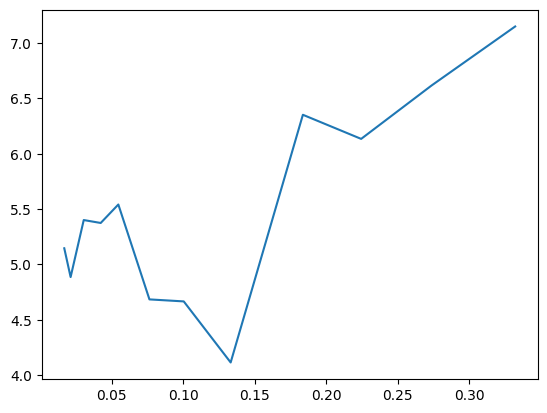

In [98]:
## Your code here
Cv = np.array([np.var(T[i][:, 4]) for i in range(12)]) # 4 should be the total energy
Cv *= kB / (kB * avgs[0, :])**2
plt.plot(avgs[0] * kB / epsilon, Cv / (38 * kB))
plt.show()

We note, that the peak does not appear, but the trend is similar (increasing $C_V$, neglecting the peack) and the magnitudes are also the same. However, when only calculating the variance of the potential energy, a more similar result can be observed:

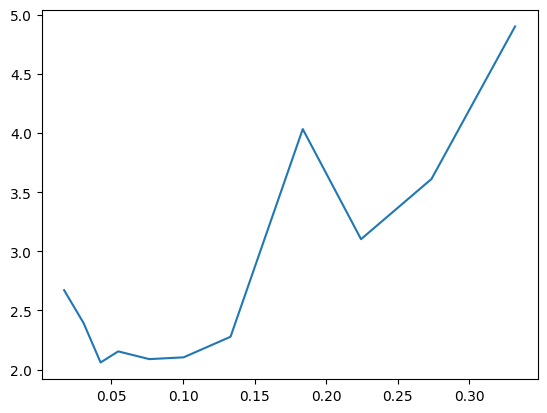

In [100]:
Cv = np.array([np.var(T[i][:, 2]) for i in range(12)]) # 4 should be the total energy
Cv *= kB / (kB * avgs[0, :])**2
plt.plot(avgs[0] * kB / epsilon, Cv / (38 * kB))
plt.show()

But I am not sure whether the variance should be with respect to potential or total energy. The referenced paper was not conclusive.

#### End Assignment 5